# Image Segmentation by Supervised Learning

## import libraries

In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [259]:
directory_data  = './'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

image_train     = data['image_train']
mask_train      = data['mask_train']

image_test      = data['image_test']
mask_test       = data['mask_test']

num_data_train  = image_train.shape[0]
num_data_test   = image_test.shape[0]

In [260]:
print('*************************************************')
print('size of x_train :', image_train.shape)
print('size of y_train :', mask_train.shape)
print('*************************************************')
print('size of x_test :', image_test.shape)
print('size of y_test :', mask_test.shape)
print('*************************************************')

*************************************************
size of x_train : (1000, 32, 32)
size of y_train : (1000, 32, 32)
*************************************************
size of x_test : (1000, 32, 32)
size of y_test : (1000, 32, 32)
*************************************************


## plot data

In [261]:
def plot_image(title, image, mask):
    
    nRow = 2
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
    
    for c in range(nCol):
        axes[0, c].imshow(image[c], cmap='gray')
        axes[1, c].imshow(mask[c], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

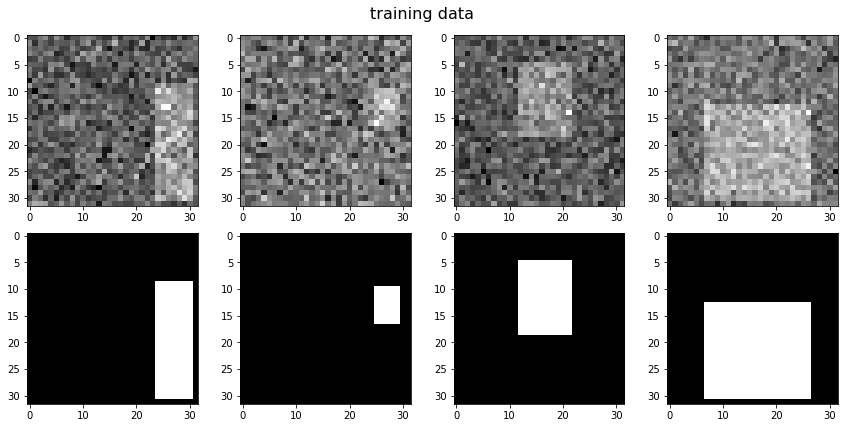

In [262]:
plot_image('training data', image_train, mask_train)

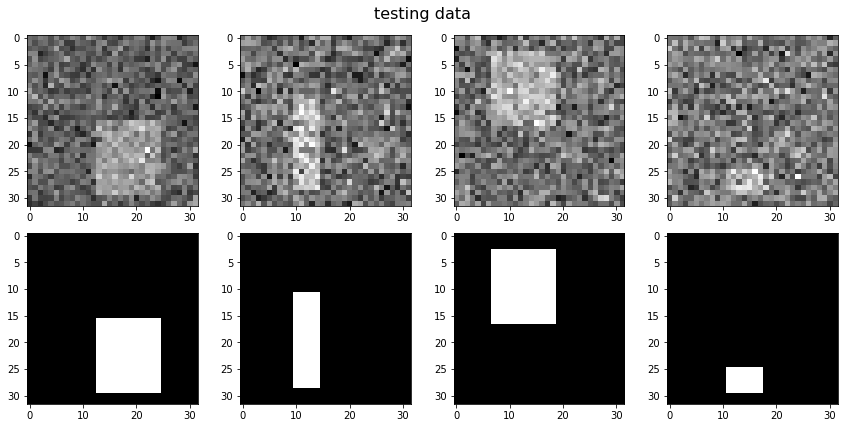

In [263]:
plot_image('testing data', image_test, mask_test)

## custom data loader for the PyTorch framework

In [264]:
class dataset(Dataset):
    
    def __init__(self, image, mask, use_transform=False):
        
        self.image          = image
        self.mask           = mask
        self.use_transform  = use_transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        mask    = self.mask[index]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        mask    = torch.FloatTensor(mask).unsqueeze(dim=0)
        
        return (image, mask)
    

    def __len__(self):

        number_image = self.image.shape[0]

        return number_image
    

## setting device

In [265]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [266]:
print(device)

cpu


## construct datasets and dataloaders for testing and testing

In [267]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 10
#
# ==================================================

dataset_train       = dataset(image_train, mask_train, True)
dataset_test        = dataset(image_test, mask_test, False)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=False)

## construct a neural network 

In [268]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1, bias=True),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------   
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [269]:
model       = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#
learning_rate   = 0.0009
alpha           = 0.000000000001
alpha_2         = 03.00000000001
number_epoch    = 200
optimizer       = torch.optim.Adam(model.parameters(), lr=learning_rate)
#
# ==================================================

## compute the prediction

In [270]:
def compute_prediction(model, input):

    prediction = model(input)
    #print(prediction.size()) = (batch_size, 1, 32, 32)
    return prediction

## compute the loss

In [271]:
def compute_loss_data_fidelity(prediction, mask):
    # ==================================================
    # fill up the blank
    # prediction, mask size = (batch_size, 1, 32, 32)

    loss = nn.BCELoss()(prediction, mask)

    #
    # ==================================================

    return loss

In [272]:
def compute_loss_regularization(prediction):
    # ==================================================
    # fill up the blank
    #
    
    num_data = (prediction.shape[0])*prediction.shape[2]*prediction.shape[3]
    #zero_x_column = np.zeros((prediction.shape[0],1))  
    #zero_y_column = np.zeros((1,prediction.shape[1])) 

    x_diff_array = torch.abs(torch.diff(prediction, axis=0))
    y_diff_array = torch.abs(torch.diff(prediction, axis=1))

    #x_diff_boundary = np.hstack([x_diff_array,zero_x_column])
    # y_diff_boundary = np.vstack([y_diff_array, zero_y_column])
    loss = (torch.sum(x_diff_array) + torch.sum(y_diff_array)) / num_data
   
    #
    # ==================================================

    return loss

In [273]:
def compute_loss(prediction, mask, alpha):
    # ==================================================
    # fill up the blank
    #

    loss_data_fidelity  = compute_loss_data_fidelity(prediction, mask)
    loss_regularization = compute_loss_regularization(prediction)
    loss                = loss_data_fidelity + alpha*loss_regularization
    
    #
    # ==================================================

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [274]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy

In [275]:
def compute_accuracy(prediction, mask):
    
    prediction  = prediction.squeeze(axis=1)
    binary      = (prediction >= 0.5)
    mask        = mask.squeeze(axis=1).bool()
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## Variable for the learning curves

In [276]:
loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [277]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.train()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)
        
        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(prediction, mask, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}
    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## test

In [278]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    accuracy_epoch              = []

    model.eval()

    for index_batch, (image, mask) in enumerate(dataloader):

        image       = image.to(device)
        mask        = mask.to(device)

        # ==================================================
        # fill up the blank
        #
        prediction  = compute_prediction(model, image)
        (loss, loss_data_fidelity, loss_regularization) = compute_loss(prediction, mask, alpha)
        
        loss_value                  = compute_loss_value(loss)
        loss_data_fidelity_value    = compute_loss_value(loss_data_fidelity)
        loss_regularization_value   = compute_loss_value(loss_regularization)
        accuracy                    = compute_accuracy(prediction, mask)
        #
        # ==================================================
        
        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        accuracy_epoch.append(accuracy+alpha_2)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    accuracy_mean   = np.mean(accuracy_epoch)
    accuracy_std    = np.std(accuracy_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    accuracy            = {'mean' : accuracy_mean, 'std' : accuracy_std}

    return (loss, loss_data_fidelity, loss_regularization, accuracy)

## train and test

In [279]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, accuracy_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    accuracy_train_mean[i]  = accuracy_train['mean']
    accuracy_train_std[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, accuracy_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    accuracy_test_mean[i]  = accuracy_test['mean']
    accuracy_test_std[i]   = accuracy_test['std']

100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


---

## functions for presenting the results

---

In [280]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [281]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [282]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [283]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [284]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [285]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [286]:
def function_result_07():
    
    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [287]:
def function_result_08():
    
    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [288]:
def function_result_09():

    nRow = 10
    nCol = 4 
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_train)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)

    image       = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_train.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):

            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [289]:
def function_result_10():
    
    nRow = 10
    nCol = 4 
    size = 3 

    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    number_data = len(dataset_test)
    index_image = np.linspace(0, number_data-1, nRow).astype(int)
    
    image       = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    mask        = torch.FloatTensor(dataset_test.mask[index_image]).unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, image)

    image       = image.detach().cpu().squeeze(axis=1)
    mask        = mask.detach().cpu().squeeze(axis=1)
    prediction  = prediction.detach().cpu().squeeze(axis=1)
    binary      = (prediction >= 0.5)

    for r in range(nRow):
    
            axes[r, 0].imshow(image[r], cmap='gray')
            axes[r, 1].imshow(prediction[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 2].imshow(binary[r], cmap='gray', vmin=0, vmax=1)
            axes[r, 3].imshow(mask[r], cmap='gray', vmin=0, vmax=1)

            axes[r, 0].xaxis.set_visible(False)
            axes[r, 1].xaxis.set_visible(False)
            axes[r, 2].xaxis.set_visible(False)
            axes[r, 3].xaxis.set_visible(False)
            
            axes[r, 0].yaxis.set_visible(False)
            axes[r, 1].yaxis.set_visible(False)
            axes[r, 2].yaxis.set_visible(False)
            axes[r, 3].yaxis.set_visible(False)
            
    plt.tight_layout()
    plt.show()

In [290]:
def function_result_11():
    
    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [291]:
def function_result_12():
    
    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



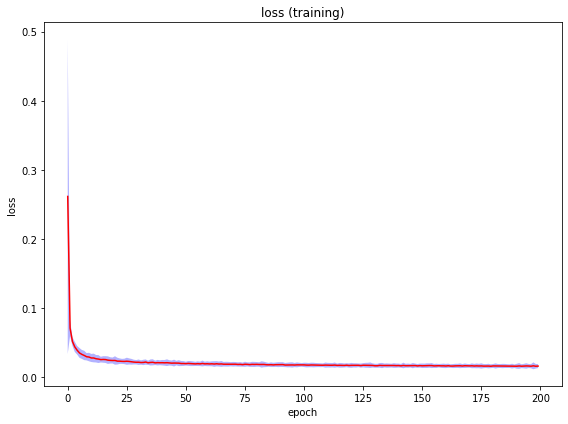


################################################################################
#
# RESULT # 02
#
################################################################################



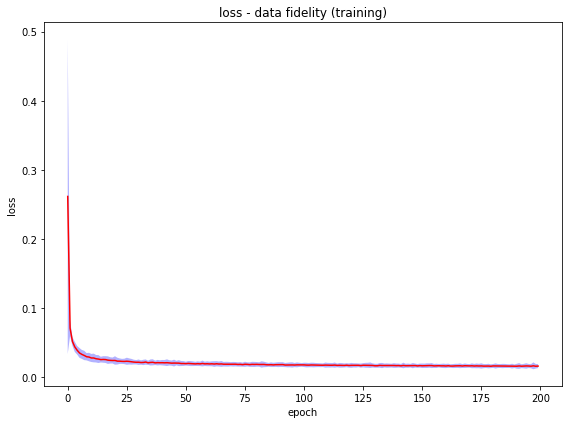


################################################################################
#
# RESULT # 03
#
################################################################################



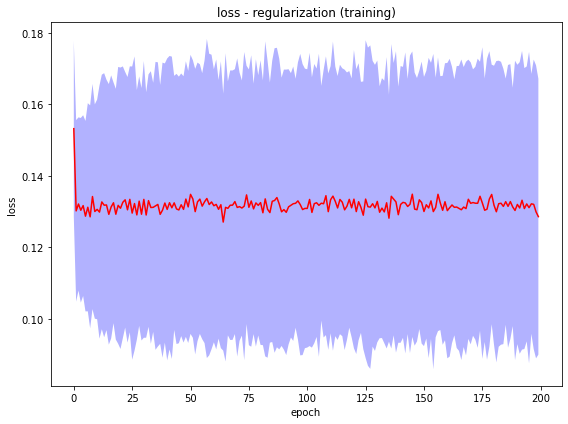


################################################################################
#
# RESULT # 04
#
################################################################################



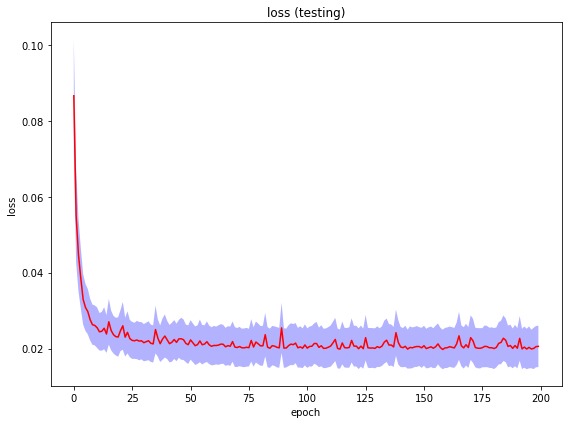


################################################################################
#
# RESULT # 05
#
################################################################################



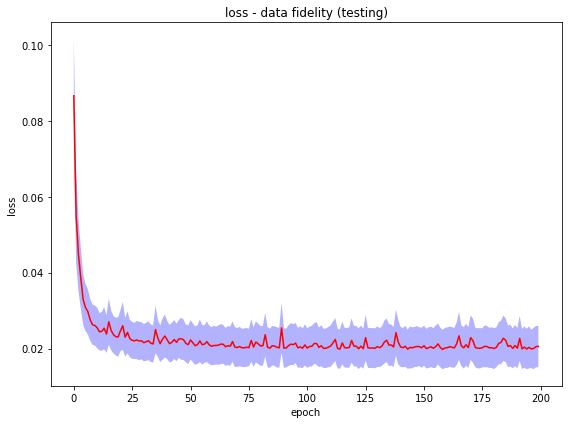


################################################################################
#
# RESULT # 06
#
################################################################################



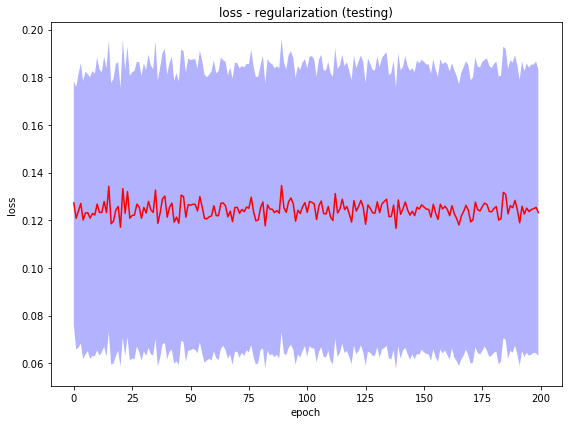


################################################################################
#
# RESULT # 07
#
################################################################################



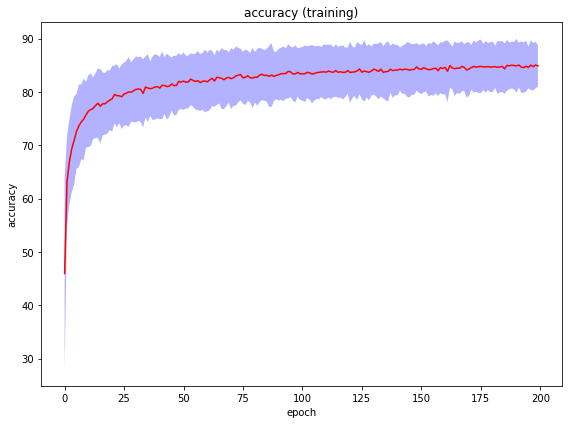


################################################################################
#
# RESULT # 08
#
################################################################################



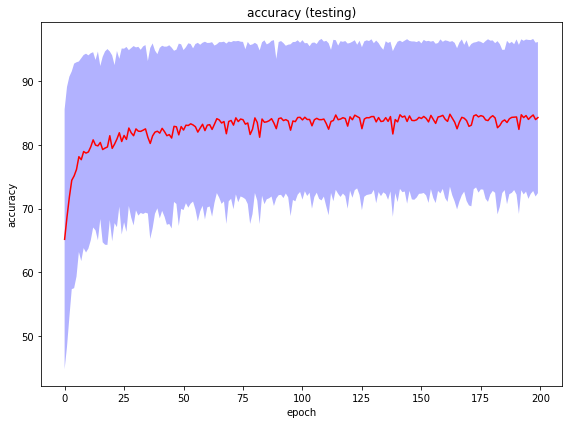


################################################################################
#
# RESULT # 09
#
################################################################################



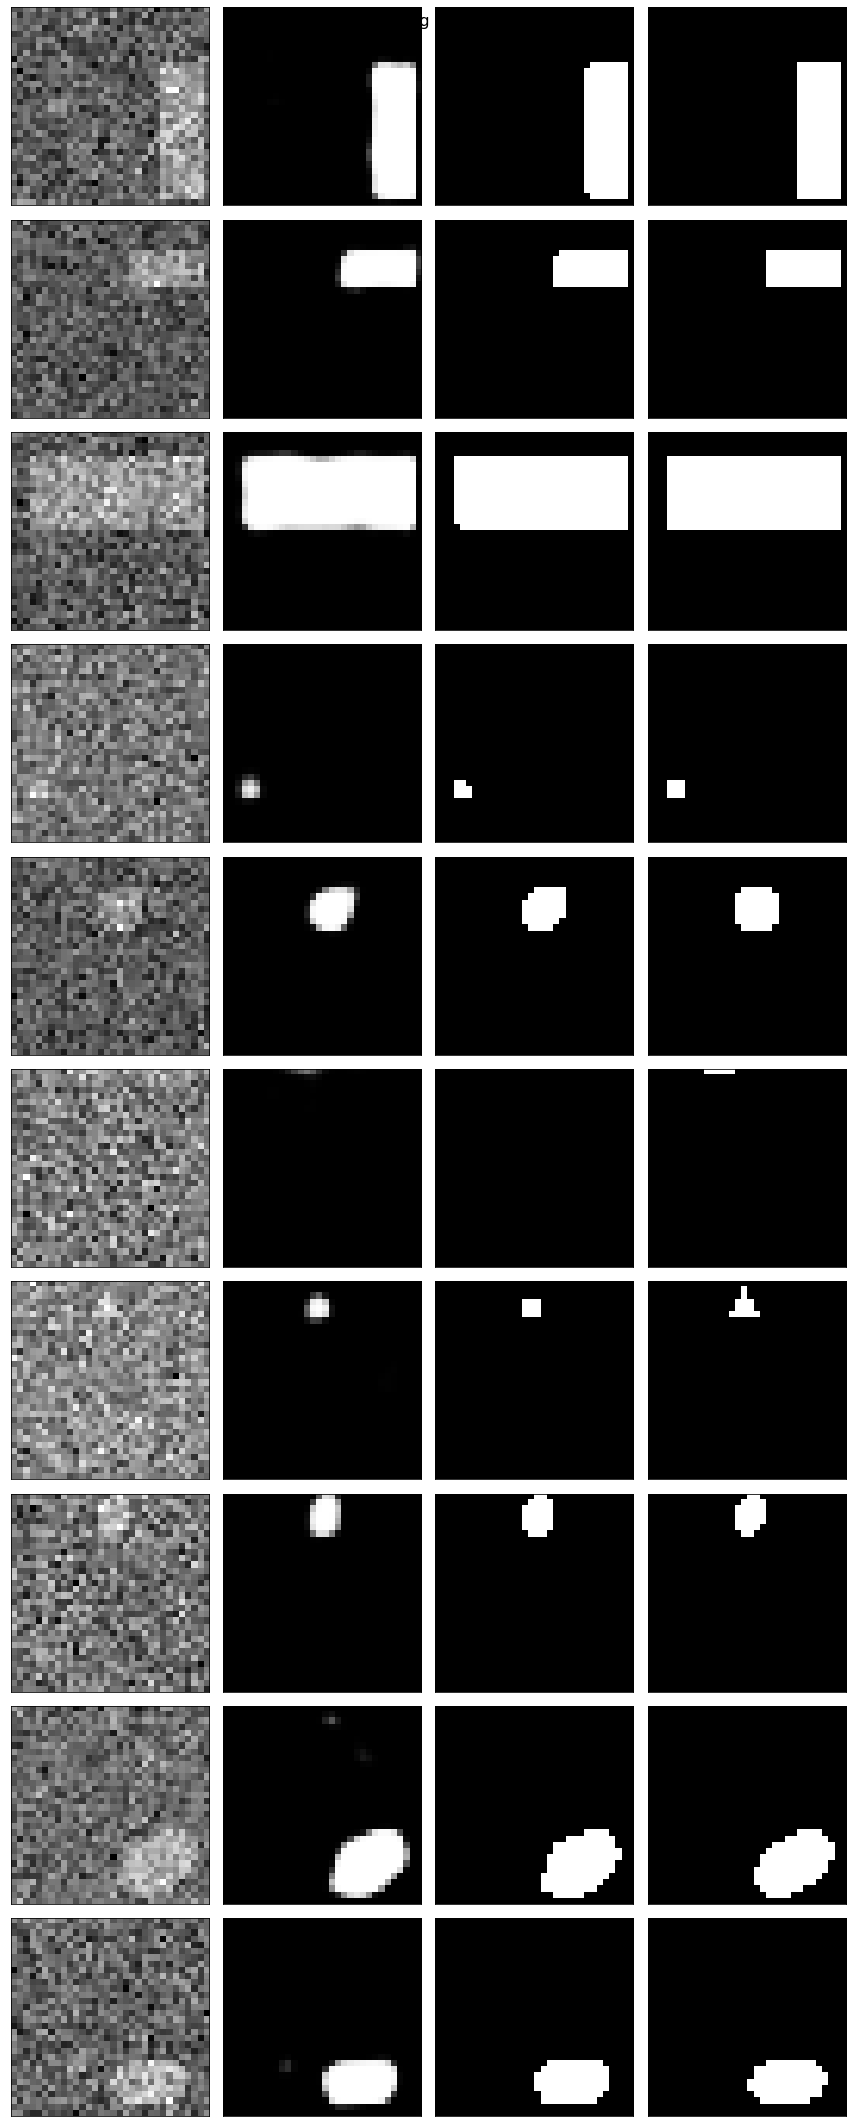


################################################################################
#
# RESULT # 10
#
################################################################################



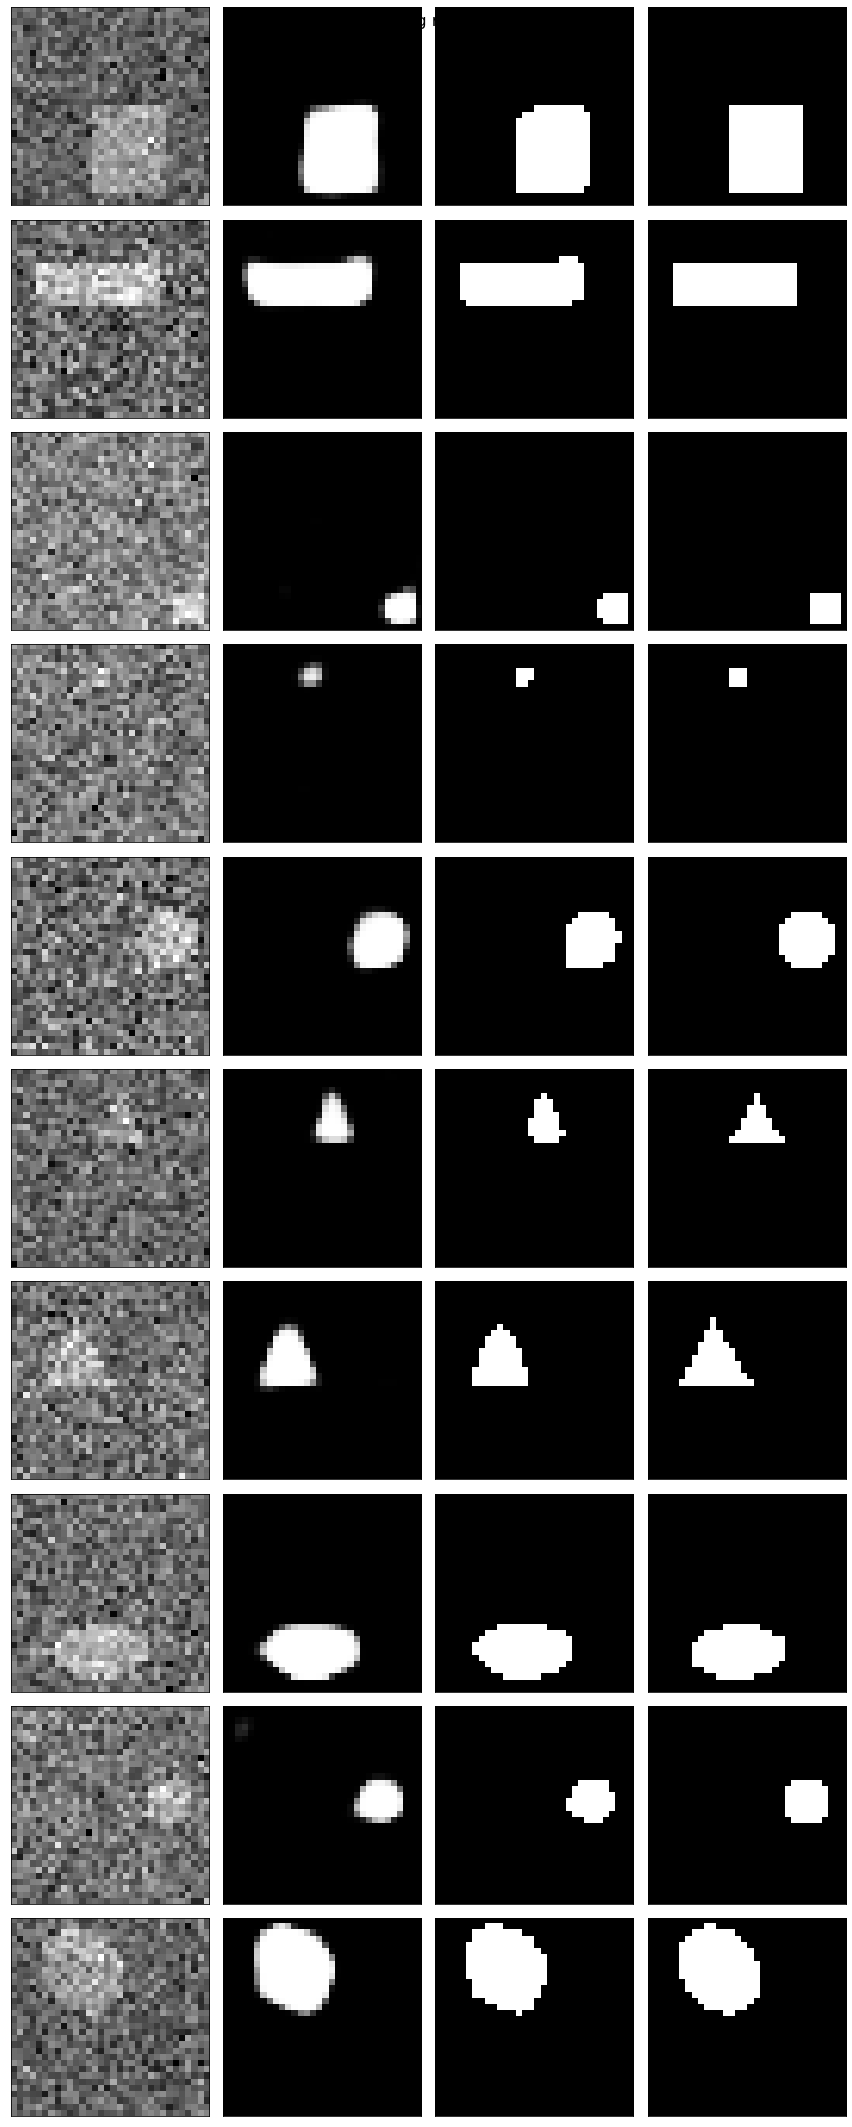


################################################################################
#
# RESULT # 11
#
################################################################################

final training accuracy = 84.88733673

################################################################################
#
# RESULT # 12
#
################################################################################

final testing accuracy = 84.27217102


In [292]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)